# Decomposição de Espectro

### Criar a feature de referência

In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import mlflow
mlflow.set_experiment('Projeto Aplicado XPE - Detector de Deep Fake')

<Experiment: artifact_location='file:///Volumes/1TB/Proj-Aplicado-XPE-MBA-Machine-Learning/notebooks/mlruns/706091484860546630', creation_time=1688931623478, experiment_id='706091484860546630', last_update_time=1688931623478, lifecycle_stage='active', name='Projeto Aplicado XPE - Detector de Deep Fake', tags={}>

### celebdf

In [2]:
# dataframe
dataset = 'celebdf'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)

In [3]:
# from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [4]:
data= {}
epsilon = 1e-8
N = 300
y = []
error = []
number_iter = 1500
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)
cont = 0


#fake data
for filename in dataframe_faces['face'][dataframe_faces['label']=='0']:
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0


for filename in dataframe_faces['face'][dataframe_faces['label']=='1']:     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('spectral_'+dataset+'.pkl', 'wb')
pickle.dump(data, output)
output.close()

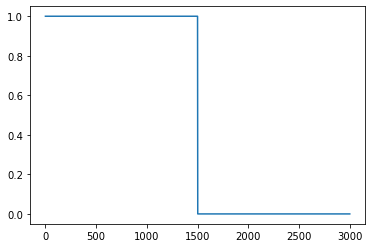

In [5]:
# load feature file
pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

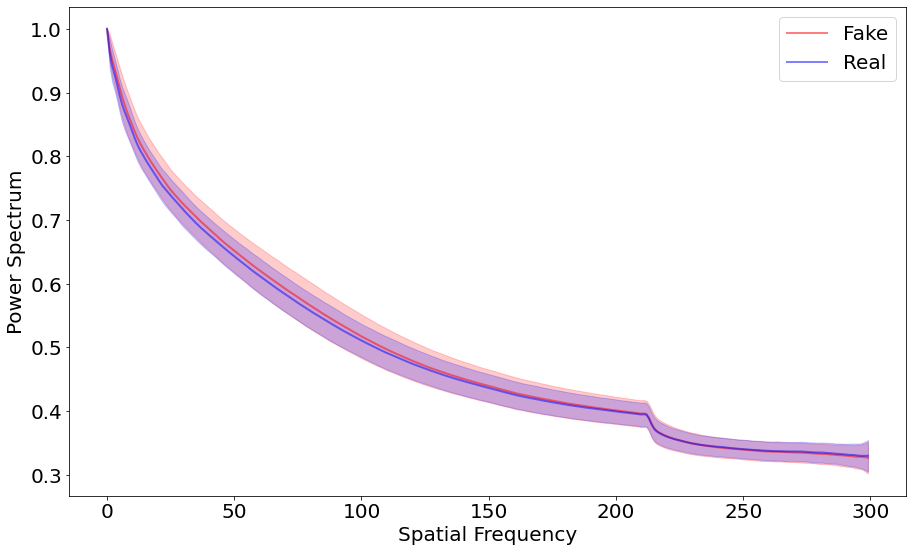

In [6]:
#check espectro:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

In [7]:
num = 1
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    svclassifier = SVC(kernel='linear')
    svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
    svclassifier_p = SVC(kernel='poly')
    logreg = LogisticRegression(solver='liblinear', max_iter=1000)
    modelos_dict = {'svclassifier':svclassifier,'svclassifier_r':svclassifier_r,'svclassifier_p':svclassifier_p,'logreg':logreg}
    #modelos = [svclassifier,svclassifier_r,svclassifier_p,logreg]
    
    for modelo in modelos_dict.keys():
        processamento = 'spec_'+modelo+'_'+ dataset
        with mlflow.start_run(run_name=processamento):
            model_class = modelos_dict[modelo]
            model_class.fit(X_train, y_train)
            mlflow.sklearn.log_model(model_class,'processamento')
            previsoes = model_class.predict(X_test)
            try:
                prob_previsao = model_class.predict_proba(X_test)[:,1]
            except:
                prob_previsao = previsoes
            report = classification_report(y_test, previsoes, output_dict=True)
            acuracia = accuracy_score(y_test, previsoes)
            mlflow.log_metric('accuracy', acuracia)
            mlflow.log_metric('precision_0', report['0.0']['precision'])
            mlflow.log_metric('recall_0', report['0.0']['recall'])
            mlflow.log_metric('f1-score_0', report['0.0']['f1-score'])
            mlflow.log_metric('precision_1', report['1.0']['precision'])
            mlflow.log_metric('recall_1', report['1.0']['recall'])
            mlflow.log_metric('f1-score_1', report['1.0']['f1-score'])
            
            auc = roc_auc_score(y_test, prob_previsao)
            mlflow.log_metric('roc_auc',auc)
            matriz_confusao = confusion_matrix(y_test,previsoes)
            mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
            mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
            mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
            mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])


### faceforensics

In [8]:
# dataframe
dataset = 'faceforensics'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)

In [9]:
data= {}
epsilon = 1e-8
N = 300
y = []
error = []
number_iter = 1500
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)
cont = 0


#fake data
for filename in dataframe_faces['face'][dataframe_faces['label']=='0']:
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0


for filename in dataframe_faces['face'][dataframe_faces['label']=='1']:     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('spectral_'+dataset+'.pkl', 'wb')
pickle.dump(data, output)
output.close()

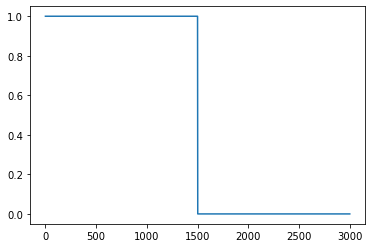

In [10]:
# load feature file
pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

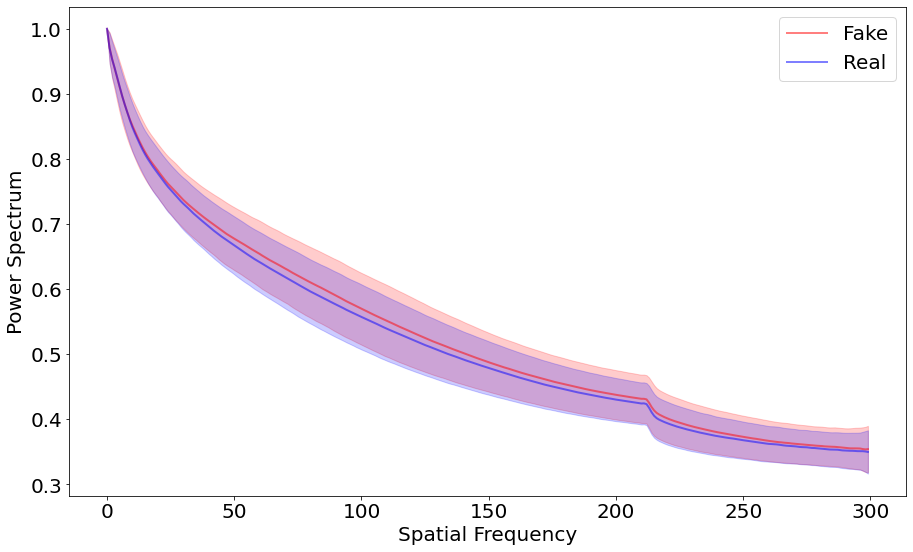

In [11]:
#check espectro:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

In [12]:
num = 1
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    svclassifier = SVC(kernel='linear')
    svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
    svclassifier_p = SVC(kernel='poly')
    logreg = LogisticRegression(solver='liblinear', max_iter=1000)
    modelos_dict = {'svclassifier':svclassifier,'svclassifier_r':svclassifier_r,'svclassifier_p':svclassifier_p,'logreg':logreg}
    #modelos = [svclassifier,svclassifier_r,svclassifier_p,logreg]
    
    for modelo in modelos_dict.keys():
        processamento = 'spec_'+modelo+'_'+ dataset
        with mlflow.start_run(run_name=processamento):
            model_class = modelos_dict[modelo]
            model_class.fit(X_train, y_train)
            mlflow.sklearn.log_model(model_class,'processamento')
            previsoes = model_class.predict(X_test)
            try:
                prob_previsao = model_class.predict_proba(X_test)[:,1]
            except:
                prob_previsao = previsoes
            report = classification_report(y_test, previsoes, output_dict=True)
            acuracia = accuracy_score(y_test, previsoes)
            mlflow.log_metric('accuracy', acuracia)
            mlflow.log_metric('precision_0', report['0.0']['precision'])
            mlflow.log_metric('recall_0', report['0.0']['recall'])
            mlflow.log_metric('f1-score_0', report['0.0']['f1-score'])
            mlflow.log_metric('precision_1', report['1.0']['precision'])
            mlflow.log_metric('recall_1', report['1.0']['recall'])
            mlflow.log_metric('f1-score_1', report['1.0']['f1-score'])
            
            auc = roc_auc_score(y_test, prob_previsao)
            mlflow.log_metric('roc_auc',auc)
            matriz_confusao = confusion_matrix(y_test,previsoes)
            mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
            mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
            mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
            mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])


### DFDC

In [13]:
# dataframe
dataset = 'dfdc'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)

In [14]:
data= {}
epsilon = 1e-8
N = 300
y = []
error = []
number_iter = 1500
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)
cont = 0


#fake data
for filename in dataframe_faces['face'][dataframe_faces['label']=='0']:
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0


for filename in dataframe_faces['face'][dataframe_faces['label']=='1']:     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('spectral_'+dataset+'.pkl', 'wb')
pickle.dump(data, output)
output.close()

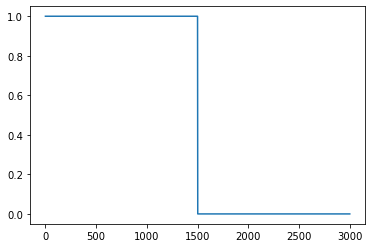

In [15]:
# load feature file
pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

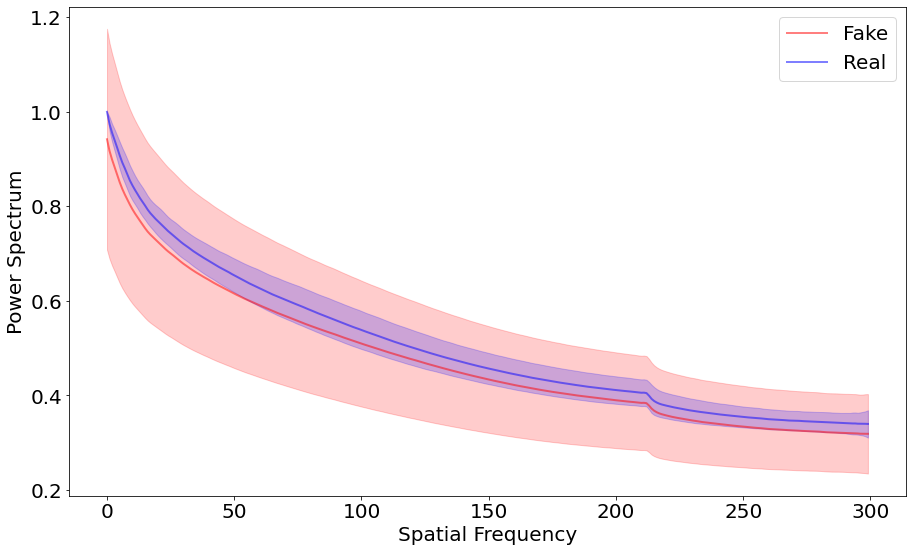

In [16]:
#check espectro:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

In [17]:
num = 1
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    pkl_file = open('spectral_'+dataset+'.pkl', 'rb')
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    svclassifier = SVC(kernel='linear')
    svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
    svclassifier_p = SVC(kernel='poly')
    logreg = LogisticRegression(solver='liblinear', max_iter=1000)
    modelos_dict = {'svclassifier':svclassifier,'svclassifier_r':svclassifier_r,'svclassifier_p':svclassifier_p,'logreg':logreg}
    #modelos = [svclassifier,svclassifier_r,svclassifier_p,logreg]
    
    for modelo in modelos_dict.keys():
        processamento = 'spec_'+modelo+'_'+ dataset
        with mlflow.start_run(run_name=processamento):
            model_class = modelos_dict[modelo]
            model_class.fit(X_train, y_train)
            mlflow.sklearn.log_model(model_class,'processamento')
            previsoes = model_class.predict(X_test)
            try:
                prob_previsao = model_class.predict_proba(X_test)[:,1]
            except:
                prob_previsao = previsoes
            report = classification_report(y_test, previsoes, output_dict=True)
            acuracia = accuracy_score(y_test, previsoes)
            mlflow.log_metric('accuracy', acuracia)
            mlflow.log_metric('precision_0', report['0.0']['precision'])
            mlflow.log_metric('recall_0', report['0.0']['recall'])
            mlflow.log_metric('f1-score_0', report['0.0']['f1-score'])
            mlflow.log_metric('precision_1', report['1.0']['precision'])
            mlflow.log_metric('recall_1', report['1.0']['recall'])
            mlflow.log_metric('f1-score_1', report['1.0']['f1-score'])
            
            auc = roc_auc_score(y_test, prob_previsao)
            mlflow.log_metric('roc_auc',auc)
            matriz_confusao = confusion_matrix(y_test,previsoes)
            mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
            mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
            mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
            mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])


***